In [1]:
# Respect the import order, otherwise there will be conflicts
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from torch.optim import Adam, AdamW
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from tqdm import tqdm
from transformers.models.paligemma.convert_paligemma_weights_to_hf import device

# Read the token from the file
with open("huggingface_token.txt", "r") as f:
    token = f.read().strip()

# Authenticate with the token
login(token)

model_name = "meta-llama/Llama-3.2-3B"
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
tokenizer.pad_token = tokenizer.eos_token

# Load the model in 4-bit quantized form for efficiency
llama_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config,
    torch_dtype=torch.float16
)

2025-01-04 22:00:40.883997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 22:00:40.893380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736024440.904261  388505 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736024440.907408  388505 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 22:00:40.920068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing LlamaForCausalLM.

All the weights of LlamaForCausalLM were initialized from the model checkpoint at meta-llama/Llama-3.2-3B.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LlamaForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /home/eddie/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": 128001,
  "temperature": 0.6,
  "top_p": 0.9
}



In [3]:
from pykeen.triples import TriplesFactory
import pandas as pd
from neo4j import GraphDatabase

# Define Neo4j connections
host = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(host, auth=(user, password))

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())
    
# Cell 2: Load your graph data
data = run_query("""
    MATCH (s)-[r]->(t)
    RETURN toString(s.name) as source, toString(t.name) AS target, type(r) as type
""")
tf = TriplesFactory.from_labeled_triples(
    data[["source", "type", "target"]].values, compact_id=False
)

# tf,_ = tf.split([0.05, 0.95])

training, testing, validation = tf.split([0.8, 0.1, 0.1])
print(f"Training samples: {training.num_triples}")

using automatically assigned random_state=1210578443
using automatically assigned random_state=1057842493


22468


In [35]:
import requests
import shelve
from functools import lru_cache
import os

CACHE_FILE = "wikidata_cache.db"

def fetch_from_wikidata(name):
    """
    Fetch data from Wikidata API for the given name.
    """
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "format": "json",
        "language": "en",
        "search": name
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        search_results = data.get("search", [])
        if search_results:
            best_result = search_results[0]
            label = best_result.get("label", "Unknown")
            description = best_result.get("description", "No description available")
            entity_id = best_result.get("id", "Unknown ID")
            return f"{label} ({entity_id}): {description}"
    print(f"Failed for {name}: {response.status_code}")
    return "No results found."

@lru_cache(maxsize=2048)
def cached_wikidata_entry(name):
    """
    Check the persistent cache or fetch and cache the result.
    """
    # Check the persistent cache first
    with shelve.open(CACHE_FILE) as cache:
        if name in cache:
            return cache[name]

    # Fetch from Wikidata if not in the persistent cache
    result = fetch_from_wikidata(name)

    # Save to persistent cache
    with shelve.open(CACHE_FILE, writeback=True) as cache:
        cache[name] = result

    return result

def clear_persistent_cache():
    """
    Clear the persistent cache.
    """
    if os.path.exists(CACHE_FILE):
        os.remove(CACHE_FILE)

In [33]:
with shelve.open(CACHE_FILE) as cache:
    df = pd.DataFrame(cache.items())
df

,0,1
0,regulates,Regulates synthesis of L1 and L11 SDY_3744 (Q27474466): microbial protein found in Shigella dysenteriae Sd197
1,A4GALT,A4GALT (Q18040751): protein-coding gene in the species Homo sapiens
2,ABCC4,ABCC4 (Q14913379): protein-coding gene in the species Homo sapiens
3,AARSD1,AARSD1 (Q18046762): protein-coding gene in the species Homo sapiens
4,A2ML1,A2ML1 (Q18051234): protein-coding gene in the species Homo sapiens
...,...,...
169,AARS,Aars (Q17378638): family name
170,ABCA12,ABCA12 (Q14881706): protein-coding gene in the species Homo sapiens
171,ABCC6,ABCC6 (Q14916171): protein-coding gene in the species Homo sapiens
172,ABCF2,ABCF2 (Q18034994): protein-coding gene in the species Homo sapiens


In [11]:
torch.cuda.empty_cache()

In [37]:
from typing import Dict
import torch
from transformers import PreTrainedModel, PreTrainedTokenizer
from tqdm import tqdm

def precompute_embeddings(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    labels: Dict[int, str],
    max_length: int = 128,
    batch_size: int = 32
) -> torch.Tensor:
    # Initialize a tensor to store the embeddings
    embeddings = torch.zeros(len(labels), model.config.hidden_size, dtype=torch.float32, device=model.device)
    
    # Create a list of labels to process in batches
    label_list = list(labels.values())
    # Use RAG embeddings
    label_list = [cached_wikidata_entry(label) for label in tqdm(label_list, desc="Getting Wikidata Entries")]
    num_batches = len(label_list) // batch_size + (1 if len(label_list) % batch_size > 0 else 0)

    for i in tqdm(range(num_batches), desc="Processing batches"):
        # Get a batch of labels
        batch_labels = label_list[i * batch_size: (i + 1) * batch_size]
        
        # Tokenize all labels in the batch
        inputs = tokenizer(batch_labels, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        inputs = {key: value.to(model.device) for key, value in inputs.items()}  # Move to device

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Get last hidden state (size: [batch_size, seq_len, hidden_size])

            # Use the [CLS]-like token embedding (first token) for each label
            embeddings_batch = hidden_states[:, 0, :].to(dtype=torch.float32)  # Shape: [batch_size, hidden_size]

            # Store the embeddings in the correct indices
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(labels))
            embeddings[start_idx:end_idx] = embeddings_batch
    
    return embeddings

relation_llama_embeddings = precompute_embeddings(llama_model, tokenizer, tf.relation_id_to_label)
entity_llama_embeddings = precompute_embeddings(llama_model, tokenizer, tf.entity_id_to_label)

Processing batches: 100%|██████████| 156/156 [03:05<00:00,  1.19s/it]


In [ ]:
# Destroy embeddings
xavier_uniform_(relation_llama_embeddings)
xavier_uniform_(entity_llama_embeddings)

In [ ]:

"""
* Working llama embedding pipeline
"""

from pykeen.evaluation import RankBasedEvaluator
from pykeen.nn.init import init_phases, xavier_uniform_
from pykeen.nn.modules import FunctionalInteraction
from pykeen.models import ERModel
from pykeen.nn.representation import Embedding
from pykeen.nn.init import xavier_uniform_
from pykeen.utils import negative_norm

class LLamaEntityRepresentation(Embedding):
    """Entity representation that combines complex RotatE embeddings with dummy embeddings."""

    def __init__(
        self,
        max_id: int,
        embedding_dim: int,
        llama_dim: int,
        llama_embeddings: torch.Tensor,
        initializer=xavier_uniform_,
        **kwargs
    ):
        # Initialize complex embeddings for RotatE
        super().__init__(
            max_id=max_id,
            shape=embedding_dim,
            initializer=initializer,
            dtype=torch.cfloat,
            **kwargs
        )
        
        self.llama_projection = torch.nn.Linear(
            in_features=llama_model.config.hidden_size,
            out_features=llama_dim,
            bias=True
        )
        self.llama_embeddings = nn.Embedding.from_pretrained(llama_embeddings, freeze=True)

    def _plain_forward(self, indices=None):
        # Get complex RotatE embeddings
        rotate_embeddings = super()._plain_forward(indices)
        
        # Handle case when indices are None (return all embeddings)
        if indices is None:
            llama__embeddings = self.llama_embeddings.weight
        else:
            llama__embeddings = self.llama_embeddings(indices)
        
        llama_projection = self.llama_projection(llama__embeddings)
        llama_projection = torch.nn.functional.normalize(llama_projection, p=2, dim=-1)
        
        # print(f"Embeddings: {llama_projection.shape}, {indices is None}, {indices.shape if indices is not None else None}")
        return rotate_embeddings, llama_projection

class RotatEDummyInteraction(FunctionalInteraction):
    """Extended RotatE interaction that handles both complex and dummy embeddings."""
    
    def forward(self, h, r, t):
        # Unpack complex and dummy parts
        h_complex, h_dummy = h
        t_complex, t_dummy = t
        r_complex, r_dummy = r
        
        # Regular RotatE score with complex embeddings
        if h_complex.dim() == 3 and r_complex.dim() == 3 and t_complex.dim() == 3:
            h_complex = h_complex.expand(r_complex.shape[0], -1, -1)
            t_complex = t_complex.expand(r_complex.shape[0], -1, -1)
            
        # Compute RotatE interaction in complex space
        rotated_h = h_complex * r_complex
        rotate_score = negative_norm(rotated_h - t_complex, p=2, power_norm=False)
        
        # print(f"pre: h_dummy: {h_dummy.shape}, r_dummy: {r_dummy.shape}, t_dummy: {t_dummy.shape}")
        # Handle dummy embeddings with simple multiplication
        if h_dummy.dim() == 3 and r_dummy.dim() == 3 and t_dummy.dim() == 3:
            h_dummy = h_dummy.expand(r_dummy.shape[0], -1, -1)
            t_dummy = t_dummy.expand(r_dummy.shape[0], -1, -1)
        
        # print(f"pos: h_dummy: {h_dummy.shape}, r_dummy: {r_dummy.shape}, t_dummy: {t_dummy.shape}")
        dummy_score = (h_dummy * r_dummy * t_dummy).sum(dim=-1)
        
        # Combine scores
        return rotate_score + dummy_score

class RotatEWithDummy(ERModel):
    """RotatE model extended with dummy embeddings."""
    
    def __init__(
        self,
        num_entities: int,
        num_relations: int,
        embedding_dim: int = 200,
        llama_dim: int = 50,
        entity_initializer=xavier_uniform_,
        relation_initializer=init_phases,
        **kwargs
    ):
        # Initialize entity representations (both complex and dummy)
        entity_representations = LLamaEntityRepresentation(
            max_id=num_entities,
            embedding_dim=embedding_dim,
            llama_dim=llama_dim,
            llama_embeddings = entity_llama_embeddings,
            initializer=entity_initializer,
        )
        
        # Initialize relation representations (both complex and dummy)
        relation_representations = LLamaEntityRepresentation(
            max_id=num_relations,
            embedding_dim=embedding_dim,
            llama_dim=llama_dim,
            llama_embeddings = relation_llama_embeddings,
            initializer=relation_initializer,
        )
        
        # Initialize the model with custom interaction
        super().__init__(
            entity_representations=entity_representations,
            relation_representations=relation_representations,
            interaction=RotatEDummyInteraction,
            **kwargs
        )

# Pipeline usage
result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=RotatEWithDummy,
    model_kwargs={
        'num_entities': tf.num_entities,
        'num_relations': tf.num_relations,
        'embedding_dim': 128,  # Complex embedding dimension
        'llama_dim': 32,
    },
    optimizer='adam',
    stopper='early',
    epochs=100,
    random_seed=42,
)
result.plot_losses()
evaluator = RankBasedEvaluator()
# Evaluate the model
metrics = evaluator.evaluate(
    result.model,
    testing.mapped_triples,
    additional_filter_triples=[training.mapped_triples, validation.mapped_triples],
)
# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Rank: {metrics.get_metric('mean_rank')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/eddie/.data/pykeen/checkpoints/best-model-weights-79e877ca-358f-46e2-89ac-10e1eaed2faf.pt


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 8.98s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.010501957992168031. Saved model weights to /home/eddie/.data/pykeen/checkpoints/best-model-weights-79e877ca-358f-46e2-89ac-10e1eaed2faf.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 7.26s seconds


Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 5.85s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 30. The best result 0.010501957992168031 occurred at epoch 10.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /home/eddie/.data/pykeen/checkpoints/best-model-weights-79e877ca-358f-46e2-89ac-10e1eaed2faf.pt
/home/eddie/Nextcloud/2024ws/tda_51056/venv/lib/python3.12/site-packages/pykeen/stoppers/early_stopping.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longe

Evaluating on cuda:0:   0%|          | 0.00/2.81k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 9.29s seconds


Evaluating on cuda:0:   0%|          | 0.00/2.81k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 7.85s seconds


Hits@1: 0.002670940170940171
Hits@3: 0.006588319088319089
Hits@5: 0.008903133903133903
Hits@10: 0.012464387464387465
Mean Rank: 6105.05419921875
Mean Reciprocal Rank: 0.006822538562119008


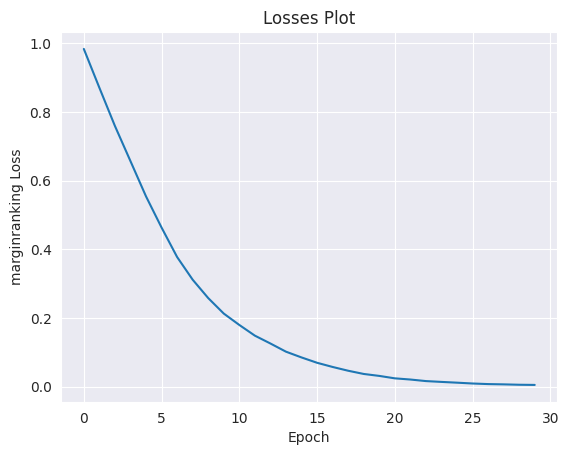

In [45]:
result.losses
"""
* Baseline
"""
result = pipeline(
    training=training,
    training_kwargs= {
        'batch_size': 1024
    },
    testing=testing,
    validation=validation,
    model="RotatE",
    stopper="early",
    epochs=100,
    dimensions=128,
    random_seed=420,
    device='cuda',
)
result.plot_losses()

evaluator = RankBasedEvaluator()
# Evaluate the model
metrics = evaluator.evaluate(
    result.model,
    testing.mapped_triples,
    additional_filter_triples=[training.mapped_triples, validation.mapped_triples],
)
# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Rank: {metrics.get_metric('mean_rank')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

In [27]:
result.losses
"""
* Working dummy embedding pipeline
"""

from pykeen.models import ERModel
import torch
from pykeen.nn.representation import Embedding
from pykeen.nn.init import init_phases, xavier_uniform_
from pykeen.nn.modules import FunctionalInteraction
from pykeen.utils import negative_norm, ensure_complex

class RotatEDummyEntityRepresentation(Embedding):
    """Entity representation that combines complex RotatE embeddings with dummy embeddings."""

    def __init__(
        self,
        num_entities: int,
        embedding_dim: int,
        dummy_dim: int,
        initializer=xavier_uniform_,
        **kwargs
    ):
        # Initialize complex embeddings for RotatE
        super().__init__(
            max_id=num_entities,
            shape=embedding_dim,
            initializer=initializer,
            dtype=torch.cfloat,
            **kwargs
        )
        
        # Initialize additional dummy embeddings (real-valued)
        self.dummy_embeddings = torch.nn.Embedding(num_entities, dummy_dim)
        torch.nn.init.xavier_uniform_(self.dummy_embeddings.weight)

    def _plain_forward(self, indices=None):
        # Get complex RotatE embeddings
        rotate_embeddings = super()._plain_forward(indices)
        
        if indices is None:
            dummy_embeddings = self.dummy_embeddings.weight
        else:
            dummy_embeddings = self.dummy_embeddings(indices.to(self.device))
        
        print(f"Embeddings: {dummy_embeddings.shape}, {indices is None}, {indices.shape if indices is not None else None}")
        return rotate_embeddings, dummy_embeddings

class RotatEDummyInteraction(FunctionalInteraction):
    """Extended RotatE interaction that handles both complex and dummy embeddings."""
    
    def forward(self, h, r, t):
        # Unpack complex and dummy parts
        h_complex, h_dummy = h
        t_complex, t_dummy = t
        r_complex, r_dummy = r
        
        # Regular RotatE score with complex embeddings
        if h_complex.dim() == 3 and r_complex.dim() == 3 and t_complex.dim() == 3:
            h_complex = h_complex.expand(r_complex.shape[0], -1, -1)
            t_complex = t_complex.expand(r_complex.shape[0], -1, -1)
            
        # Compute RotatE interaction in complex space
        rotated_h = h_complex * r_complex
        rotate_score = negative_norm(rotated_h - t_complex, p=2, power_norm=False)
        
        print(f"pre: h_dummy: {h_dummy.shape}, r_dummy: {r_dummy.shape}, t_dummy: {t_dummy.shape}")
        # Handle dummy embeddings with simple multiplication
        if h_dummy.dim() == 3 and r_dummy.dim() == 3 and t_dummy.dim() == 3:
            h_dummy = h_dummy.expand(r_dummy.shape[0], -1, -1)
            t_dummy = t_dummy.expand(r_dummy.shape[0], -1, -1)
        
        print(f"pos: h_dummy: {h_dummy.shape}, r_dummy: {r_dummy.shape}, t_dummy: {t_dummy.shape}")
        dummy_score = (h_dummy * r_dummy * t_dummy).sum(dim=-1)
        
        # Combine scores
        return rotate_score + dummy_score

class RotatEWithDummy(ERModel):
    """RotatE model extended with dummy embeddings."""
    
    def __init__(
        self,
        num_entities: int,
        num_relations: int,
        embedding_dim: int = 200,
        dummy_dim: int = 50,
        entity_initializer=xavier_uniform_,
        relation_initializer=init_phases,
        **kwargs
    ):
        # Initialize entity representations (both complex and dummy)
        entity_representations = LLamaEntityRepresentation(
            num_entities=num_entities,
            embedding_dim=embedding_dim,
            dummy_dim=dummy_dim,
            initializer=entity_initializer
        )
        
        # Initialize relation representations (both complex and dummy)
        relation_representations = LLamaEntityRepresentation(
            num_entities=num_relations,
            embedding_dim=embedding_dim,
            dummy_dim=dummy_dim,
            initializer=relation_initializer
        )
        
        # Initialize the model with custom interaction
        super().__init__(
            entity_representations=entity_representations,
            relation_representations=relation_representations,
            interaction=RotatEDummyInteraction,
            **kwargs
        )

# Pipeline usage
result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=RotatEWithDummy,
    model_kwargs={
        'num_entities': tf.num_entities,
        'num_relations': tf.num_relations,
        'embedding_dim': 128,  # Complex embedding dimension
        'dummy_dim': 32,      # Dummy embedding dimension
    },
    optimizer='adam',
    stopper='early',
    epochs=1,
    random_seed=42,
)
result.plot_losses()

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/eddie/.data/pykeen/checkpoints/best-model-weights-0555768f-6ec2-4073-9b19-2101b78ee9c3.pt


Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
pre: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
pos: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
pre: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
pos: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
pre: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([25

Training epochs on cuda:0:   0%|          | 0/1 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/88 [00:00<?, ?batch/s]

Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
pre: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
pos: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
pre: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
pos: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([256, 32]), t_dummy: torch.Size([256, 32])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
Embeddings: torch.Size([256, 32]), False, torch.Size([256])
pre: h_dummy: torch.Size([256, 32]), r_dummy: torch.Size([25

Evaluating on cuda:0:   0%|          | 0.00/2.81k [00:00<?, ?triple/s]

Embeddings: torch.Size([19930, 32]), True, None
Embeddings: torch.Size([2808, 1, 32]), False, torch.Size([2808, 1])
Embeddings: torch.Size([2808, 1, 32]), False, torch.Size([2808, 1])
Embeddings: torch.Size([19930, 32]), True, None
Embeddings: torch.Size([1376, 1, 32]), False, torch.Size([1376, 1])
Embeddings: torch.Size([1376, 1, 32]), False, torch.Size([1376, 1])
Embeddings: torch.Size([19930, 32]), True, None
Embeddings: torch.Size([672, 1, 32]), False, torch.Size([672, 1])
Embeddings: torch.Size([672, 1, 32]), False, torch.Size([672, 1])
Embeddings: torch.Size([19930, 32]), True, None
Embeddings: torch.Size([320, 1, 32]), False, torch.Size([320, 1])
Embeddings: torch.Size([320, 1, 32]), False, torch.Size([320, 1])
Embeddings: torch.Size([19930, 32]), True, None
Embeddings: torch.Size([160, 1, 32]), False, torch.Size([160, 1])
Embeddings: torch.Size([160, 1, 32]), False, torch.Size([160, 1])
Embeddings: torch.Size([19930, 32]), True, None
Embeddings: torch.Size([64, 1, 32]), False, 

KeyboardInterrupt: 

In [ ]:
"""
* Nonworking llama embedding 1
"""
from pykeen.models import ERModel
import torch
import torch.nn as nn
from pykeen.nn.representation import Embedding
from pykeen.nn.init import xavier_uniform_
from pykeen.nn.modules import Interaction
from transformers import PreTrainedModel, PreTrainedTokenizer
from typing import Optional, Union, Dict
from torch import FloatTensor, LongTensor

class LLaMAEntityRepresentation(Embedding):
    """Entity representation that concatenates regular embeddings with LLaMA embeddings."""

    def __init__(
        self,
        max_id: int,
        embedding_dim: int,
        llama_dim: int,
        llama_model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        **kwargs
    ) -> None:
        # Ensure kwargs has the correct dtype
        kwargs['dtype'] = torch.float32
        
        # Initialize regular embeddings for entities
        super().__init__(max_id=max_id, embedding_dim=embedding_dim, **kwargs)

        # Initialize LLaMA components with explicit dtype
        self.llama_projection = nn.Linear(
            in_features=llama_model.config.hidden_size,
            out_features=llama_dim,
            bias=True
        )
        # Explicitly move weights to float32
        self.llama_projection.weight.data = self.llama_projection.weight.data.to(torch.float32)
        if self.llama_projection.bias is not None:
            self.llama_projection.bias.data = self.llama_projection.bias.data.to(torch.float32)
        
        self.llama = llama_model
        self.tokenizer = tokenizer
        self.llama_cache: Dict[int, FloatTensor] = {}

    def reset_parameters(self) -> None:
        """Reset the parameters of the model."""
        super().reset_parameters()
        # Explicitly initialize projection layer parameters
        nn.init.xavier_uniform_(self.llama_projection.weight.data)
        if self.llama_projection.bias is not None:
            nn.init.zeros_(self.llama_projection.bias.data)

    def _plain_forward(self, indices: Optional[LongTensor] = None) -> FloatTensor:
        """Get regular and LLaMA embeddings for the given indices."""
        # Get regular embeddings using the super class's _plain_forward method
        regular_embeddings = super()._plain_forward(indices)

        if indices is None:
            # Return all embeddings
            indices = torch.arange(self.max_id, device=self.device)
        
        # Process entity descriptions through LLaMA
        indices_cpu = indices.cpu().tolist()
        uncached = [idx for idx in indices_cpu if idx not in self.llama_cache]
        
        if uncached:
            # Get descriptions for uncached entities
            texts = [cached_wikidata_entry(f"Entity_{idx}") for idx in uncached]
            
            # Process through LLaMA
            inputs = self.tokenizer(
                texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(self.llama.device)
            
            with torch.no_grad():
                outputs = self.llama(**inputs)
                embeddings = outputs.last_hidden_state[:, 0, :].to(dtype=torch.float32)
                projected = self.llama_projection(embeddings)
                
                for idx, emb in zip(uncached, projected):
                    self.llama_cache[idx] = emb.to(self.device)
        
        # Get all embeddings from cache
        llama_embeddings = torch.stack([
            self.llama_cache[idx] for idx in indices_cpu
        ]).to(self.device).to(torch.float32)  # Ensure float32
        
        # Concatenate regular and LLaMA embeddings
        return torch.cat([regular_embeddings, llama_embeddings], dim=-1)

class LLaMAEmbeddingInteraction(Interaction):
    """Interaction function for the combined embeddings."""
    
    def forward(
        self,
        h: FloatTensor,
        r: FloatTensor,
        t: FloatTensor
    ) -> FloatTensor:
        # Ensure all inputs are float32
        h = h.to(torch.float32)
        r = r.to(torch.float32)
        t = t.to(torch.float32)
        
        # Adjust for evaluation
        if h.dim() == 3 and r.dim() == 3 and t.dim() == 3:
            h = h.expand(r.shape[0], -1, -1)
            t = t.expand(r.shape[0], -1, -1)
        
        # Compute scores
        return (h * r * t).sum(dim=-1)

class LLaMAEnhancedModel(ERModel):
    """Model that integrates LLaMA embeddings into entity representations."""
    
    def __init__(
        self,
        num_entities: int,
        num_relations: int,
        embedding_dim: int = 128,
        llama_dim: int = 32,
        llama_model: PreTrainedModel = None,
        tokenizer: PreTrainedTokenizer = None,
        **kwargs
    ) -> None:
        # Initialize the entity representation
        entity_representations = LLaMAEntityRepresentation(
            max_id=num_entities,
            embedding_dim=embedding_dim,
            llama_dim=llama_dim,
            llama_model=llama_model,
            tokenizer=tokenizer,
            dtype=torch.float32  # Explicitly set dtype
        )
        
        # Define the interaction function
        interaction = LLaMAEmbeddingInteraction()
        
        # Pass everything to the parent ERModel with explicit dtype
        super().__init__(
            entity_representations=entity_representations,
            relation_representations=Embedding,
            relation_representations_kwargs=dict(
                embedding_dim=embedding_dim + llama_dim,
                dtype=torch.float32  # Explicitly set dtype
            ),
            interaction=interaction,
            **kwargs
        )

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/eddie/.data/pykeen/checkpoints/best-model-weights-87c65e05-dd02-4d35-9797-50166f6a1288.pt


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 91.71s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.0019226660969878231. Saved model weights to /home/eddie/.data/pykeen/checkpoints/best-model-weights-87c65e05-dd02-4d35-9797-50166f6a1288.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Evaluating on cuda:0:   0%|          | 0.00/56.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 97.25s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

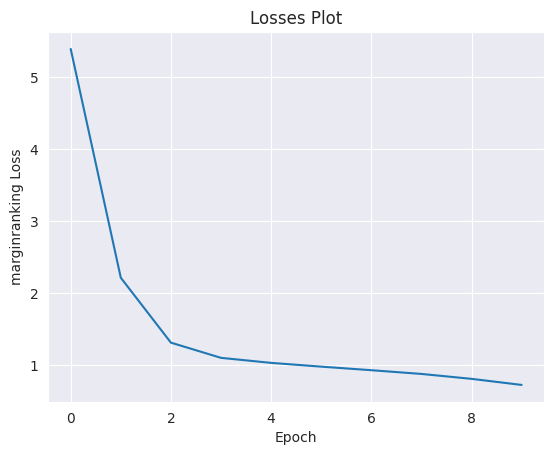

In [5]:
"""
* Working dummy embedding pipeline backup
"""
import torch
from pykeen.models import ERModel
from pykeen.nn import Embedding
from pykeen.pipeline import pipeline
from pykeen.datasets import Nations
from pykeen.nn import Interaction


class DummyEntityRepresentation(Embedding):
    """Custom entity representation that concatenates dummy embeddings."""

    def __init__(self, num_entities, embedding_dim, dummy_dim, **kwargs):
        # Initialize regular embeddings for entities
        super().__init__(max_id=num_entities, embedding_dim=embedding_dim, **kwargs)

        # Initialize dummy embeddings for entities
        self.dummy_embeddings = torch.nn.Embedding(num_entities, dummy_dim)
        torch.nn.init.xavier_uniform_(self.dummy_embeddings.weight)

    def _plain_forward(self, indices=None):
        """
        Get regular and dummy embeddings for the given indices.

        Handles the case where indices are None, meaning all embeddings are returned.
        """
        # Get regular embeddings using the super class's _plain_forward method
        regular_embeddings = super()._plain_forward(indices)

        if indices is None:
            # Return all dummy embeddings when indices are None
            dummy_embeddings = self.dummy_embeddings.weight
        else:
            # Lookup specific dummy embeddings
            dummy_embeddings = self.dummy_embeddings(indices.to(self.device))
        
        # Concatenate regular and dummy embeddings along the last dimension
        return torch.cat([regular_embeddings, dummy_embeddings], dim=-1)

class DummyEmbeddingInteraction(Interaction):
    def forward(self, h, r, t):
        
        # Adjust for evaluation
        if h.dim() == 3 and r.dim() == 3 and t.dim() == 3:
            # Broadcasting adjustments:
            # Expand h to match the first dimension of r (batch size or total triples)
            h = h.expand(r.shape[0], -1, -1)
            # Expand t similarly to match r
            t = t.expand(r.shape[0], -1, -1)
        
        # Ensure embedding dimensions match
        if h.size(-1) != r.size(-1) or t.size(-1) != r.size(-1):
            raise ValueError(f"Mismatch in embedding dimensions: "
                             f"h={h.size(-1)}, r={r.size(-1)}, t={t.size(-1)}")
        
        # Compute scores
        return (h * r * t).sum(dim=-1)

class DummyEmbeddingModel(ERModel):
    """Custom model that integrates dummy embeddings into the entity representations."""
    
    def __init__(self, num_entities, num_relations, embedding_dim=50, dummy_dim=50, **kwargs):
        # Initialize the custom entity representation
        entity_representations = DummyEntityRepresentation(
            num_entities=num_entities,
            embedding_dim=embedding_dim,
            dummy_dim=dummy_dim
        )
        
        # Define the custom interaction function
        interaction = DummyEmbeddingInteraction()
        
        # Pass everything to the parent ERModel
        super().__init__(
            entity_representations=entity_representations,
            relation_representations=Embedding,
            relation_representations_kwargs=dict(embedding_dim=embedding_dim + dummy_dim),  # Adjust relation embedding size
            interaction=interaction,
            **kwargs
        )


result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=DummyEmbeddingModel,
    model_kwargs={
        'num_entities': tf.num_entities,
        'num_relations': tf.num_relations,
        'embedding_dim': 128,  # Regular embedding size
        'dummy_dim': 32,  # Dummy embedding size
    },
    optimizer='adam',
    stopper='early',
    epochs=10,
    random_seed=42,
)
result.plot_losses()

In [6]:
"""
* Exemplary RAG pipeline
"""

import numpy as np

# Function to retrieve and process external context
def get_rag_embedding(entity_name):
    """
    Retrieve and encode Wikidata context for an entity.
    """
    # Retrieve Wikidata context
    if check_wikidata_entry(entity_name, print_results=False):
        # Example text (replace with actual retrieved Wikidata info)
        context = f"Information about {entity_name} retrieved from Wikidata."
    else:
        context = f"No Wikidata context found for {entity_name}."

    # Tokenize and encode the context using Llama
    inputs = tokenizer(context, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # Use the last hidden state as the embedding
    rag_embedding = outputs.hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()
    return rag_embedding

def generate_augmented_embeddings(triples_factory):
    """
    Generate embeddings combining Hetionet and RAG features using extracted triples.
    """
    augmented_embeddings = []
    triples = triples_factory.mapped_triples  # Extract triples as tensor [num_triples, 3]
    for triple in tqdm(triples, desc="Generating augmented embeddings"):
        head, relation, tail = triple.tolist()  # Convert tensor to list for indexing
        
        # Get entity labels for head and tail
        head_label = triples_factory.entity_to_id[head]
        tail_label = triples_factory.entity_to_id[tail]
        
        # Generate embeddings
        head_emb = get_rag_embedding(head_label)
        tail_emb = get_rag_embedding(tail_label)
        
        # Concatenate embeddings
        combined_emb = np.concatenate([head_emb, tail_emb])
        augmented_embeddings.append(combined_emb)
    
    return np.array(augmented_embeddings)

# Example: Process training data
training_augmented_embeddings = generate_augmented_embeddings(training)

# Use augmented embeddings in your model pipeline
result = pipeline(
    training=training_augmented_embeddings,
    testing=testing,  # Similarly process testing and validation
    validation=validation,
    model="RotatE",  # Use RotatE or any other model
    stopper="early",
    epochs=4,
    dimensions=256,  # Adjust dimensions to match combined embeddings
    random_seed=420,
)
result.plot_losses()

NameError: name 'tqdm' is not defined

In [ ]:
"""
* Nonworking llama pipeline 2
"""

from typing import Optional
import torch
from torch import nn
import torch.nn.functional as F
from pykeen.models import ERModel
from pykeen.nn import Embedding, Interaction
from transformers import PreTrainedModel, PreTrainedTokenizer

class LLaMaEnhancedInteraction(Interaction):
    def __init__(
        self,
        llama_model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        embedding_dim: int = 256
    ):
        print("Starting Interaction initialization")
        super().__init__()
        
        self.llama = llama_model
        self.tokenizer = tokenizer
        self.embedding_dim = embedding_dim
        
        # Explicitly set dtype for linear layers
        self.llama_projection = nn.Linear(
            self.llama.config.hidden_size,
            embedding_dim,
        ).to(dtype=torch.float32)
        
        self.combine_layer = nn.Linear(
            embedding_dim * 2,
            embedding_dim,
        ).to(dtype=torch.float32)

    def forward(self, h: torch.FloatTensor, r: torch.FloatTensor, t: torch.FloatTensor) -> torch.FloatTensor:
        # Convert entity IDs to text descriptions
        h_ids = torch.arange(len(h), device=h.device)
        t_ids = torch.arange(len(t), device=t.device)
        
        # Get LLaMA embeddings and convert to float32
        h_llama = self._get_llama_embeddings(h_ids).to(dtype=torch.float32)
        t_llama = self._get_llama_embeddings(t_ids).to(dtype=torch.float32)
        
        # Ensure all tensors are float32
        h = h.to(dtype=torch.float32)
        r = r.to(dtype=torch.float32)
        t = t.to(dtype=torch.float32)
        
        # Combine embeddings
        h_combined = self.combine_layer(torch.cat([h, h_llama], dim=-1))
        t_combined = self.combine_layer(torch.cat([t, t_llama], dim=-1))
        
        # Calculate similarity scores
        return torch.sum((h_combined + r) * t_combined, dim=-1)

    def _get_llama_embeddings(self, ids: torch.Tensor) -> torch.Tensor:
        texts = [f"Entity {ent.item()}" for ent in ids]
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.llama.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.llama(**inputs)
            # Convert from float16 to float32
            embeddings = outputs.last_hidden_state[:, 0, :].to(dtype=torch.float32)
        
        return self.llama_projection(embeddings)

class LLaMaEnhancedKGEModel(ERModel):
    def __init__(
        self,
        llama_model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        embedding_dim: int = 256,
        **kwargs,
    ) -> None:
        print("Starting model initialization")
        
        # Ensure we're working with the right precision
        self.embedding_dim = embedding_dim
        
        super().__init__(
            interaction=LLaMaEnhancedInteraction,
            interaction_kwargs=dict(
                llama_model=llama_model,
                tokenizer=tokenizer,
                embedding_dim=embedding_dim,
            ),
            entity_representations=Embedding,
            entity_representations_kwargs=dict(
                shape=(embedding_dim,),  # Note: shape must be a tuple
                initializer='xavier_uniform',
            ),
            relation_representations=Embedding,
            relation_representations_kwargs=dict(
                shape=(embedding_dim,),  # Note: shape must be a tuple
                initializer='xavier_uniform',
            ),
            **kwargs,
        )

def create_enhanced_pipeline(
    training,
    testing,
    validation,
    llama_model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    embedding_dim: int = 256,
) -> 'PipelineResult':
    """Create an enhanced pipeline combining LLaMA and PyKEEN models."""
    # Ensure LLaMA is on correct device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    llama_model = llama_model.to(device)
    
    # Create and run pipeline
    result = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        model=LLaMaEnhancedKGEModel,
        model_kwargs={
            'llama_model': llama_model,
            'tokenizer': tokenizer,
            'embedding_dim': embedding_dim,
        },
        optimizer='adam',
        optimizer_kwargs={'lr': 0.001},
        loss='marginranking',
        training_kwargs={
            'num_epochs': 1, 
            'batch_size': 128,
        },
        negative_sampler='basic',
        evaluator='rankbased',
        evaluator_kwargs={'batch_size': 128},
        stopper='early',
        stopper_kwargs={
            'frequency': 5, 
            'patience': 2,
        },
        device=device,
    )
    
    return result

In [12]:
"""
* Wikidata Analysis Pipeline
"""

import requests

def check_wikidata_entry(name, print_results=True):
    """
    Check if a given name has a corresponding Wikidata entry and optionally print the results.
    """
    url = f"https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "format": "json",
        "language": "en",
        "search": name
    }
    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            search_results = data.get("search", [])
            if print_results:
                print(f"Results for '{name}':")
                for result in search_results:
                    print(f" - Label: {result.get('label')}, Description: {result.get('description')}, ID: {result.get('id')}")
            return len(search_results) > 0  # True if at least one match found
    except Exception as e:
        print(f"Error checking {name}: {e}")
    return False

def calculate_match_percentage(names):
    """
    Calculate the percentage of names found in Wikidata.
    """
    unique_names = set(names)  # Ensure uniqueness
    matches = [check_wikidata_entry(name) for name in tqdm(unique_names, desc="Checking Wikidata")]

    found_count = sum(matches)
    total_count = len(unique_names)
    percentage_found = (found_count / total_count) * 100 if total_count > 0 else 0

    return found_count, total_count, percentage_found

# Assuming `data["source"]` is the pandas Series with the names

# Extract names as a list
names = data["source"].dropna().tolist()  # Drop any NaN values for safety

# Calculate match statistics
found_count, total_count, percentage_found = calculate_match_percentage(names)

# Print results
print(f"Checked {total_count} unique entities.")
print(f"Found Wikidata entries for {found_count} entities.")
print(f"Percentage found: {percentage_found:.2f}%")

NameError: name 'tqdm' is not defined

In [ ]:
"""
* Exemplary Llama pipeline
"""

# Example query with better generation parameters
prompt = "Quantum Mechanics is a topic inside Physics which deals with"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llama_model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
)

# Decode and print the response
print(tokenizer.decode(outputs[0], skip_special_tokens=True))